In [16]:
import torch
import torchvision
from torch import nn
from torchvision import transforms, models, datasets
from torchinfo import summary

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import copy

In [17]:
torch.manual_seed(2929)

In [18]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists.


In [19]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [20]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
#weights
base_transform = weights.transforms()
base_transform
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [21]:
# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)

# Define split ratio (2/10)
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size

# Create the splits
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(2929)
)

# Create data loaders
train_dataloader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
)

val_dataloader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
)

test_dataloader = torch.utils.data.DataLoader(
    datasets.ImageFolder(test_dir, transform=base_transform),
    batch_size=32,
    shuffle=False,
    num_workers=4,
)
# Check the class names
class_names = test_dataloader.dataset.classes
print(class_names)

['pizza', 'steak', 'sushi']


In [22]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)
#model

In [23]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'],
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

Freezing base model, change output layer

In [24]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze the last block:
for param in model.features[6:].parameters():
    param.requires_grad = True

In [25]:
output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
    )

In [26]:
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)
#model

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   Partial
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32

define train step, test step and combine them

In [27]:
def train_model(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                criterion: torch.nn.Module, 
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler,
                device: torch.device) -> Tuple[float, float]:
    
    # Set the model to training mode
    model.train()

    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        #Forward pass
        y_pred = model(X)

        #calculate  and accumulate loss
        loss = criterion(y_pred, y)
        train_loss += loss.item() 

        #Optimizer zero grad
        optimizer.zero_grad()

        #Loss backward
        loss.backward()

        #Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
            
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    # Scheduler step
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(train_loss)
    else:
        scheduler.step()

        
    return train_loss, train_acc

In [28]:
def test_model(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module,
               device: torch.device) -> Tuple[float, float]:
    #eval mode on
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        #loop through DataLoader batches:
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred = model(X)

            # Calculate and accumulate loss
            loss = criterion(test_pred, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_labels = test_pred.argmax(dim=1)
            test_acc += (y_pred_labels == y).sum().item()/len(y_pred_labels)
    
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [29]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,  # Changed from test_dataloader
          test_dataloader: torch.utils.data.DataLoader,  # Added separate test dataloader
          criterion: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          epochs: int,
          device: torch.device,
          patience: int = 5) -> Dict[str, List[float]]:
    
    # Create a dictionary to store the results
    results = {"train_loss": [], 
               "train_acc": [],
               "val_loss": [],   # Changed from test_loss 
               "val_acc": [],    # Changed from test_acc
               "test_loss": [],  # Added separate test metrics
               "test_acc": []    
              }
    
    # Early stopping variables
    best_val_acc = 0.0  # Changed from best_test_acc
    best_model_wts = copy.deepcopy(model.state_dict())
    counter = 0
    
    # Loop through the epochs
    for epoch in tqdm(range(epochs)):
        # Train the model
        train_loss, train_acc = train_model(model=model,
                                           dataloader=train_dataloader,
                                           criterion=criterion,
                                           optimizer=optimizer,
                                           scheduler=scheduler,
                                           device=device)
        
        # Validate the model
        val_loss, val_acc = test_model(model=model,  # Using test_model function for validation
                                       dataloader=val_dataloader,
                                       criterion=criterion,
                                       device=device)

        # Print the results
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")
        print(f"Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}")

        # Append the results to the dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        
        # Early stopping check - using validation accuracy
        if val_acc > best_val_acc:
            print(f"Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving model...")
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            print(f"Validation accuracy did not improve. Counter: {counter}/{patience}")
            
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break
    
    # Load the best model weights
    print(f"Loading best model with validation accuracy: {best_val_acc:.4f}")
    model.load_state_dict(best_model_wts)
    
    # Evaluate on test set
    test_loss, test_acc = test_model(model=model,
                                    dataloader=test_dataloader,
                                    criterion=criterion,
                                    device=device)
    
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")
    
    return results, model

In [30]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

results, best_model = train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=25,  # Increased from 5 to 25
    device="cuda" if torch.cuda.is_available() else "cpu",
    patience=5  # Stop if no improvement for 5 consecutive epochs
)

  4%|▍         | 1/25 [00:27<11:02, 27.62s/it]

Epoch 1/25
Train loss: 0.8354, Train accuracy: 0.6375
Val loss: 0.3780, Val accuracy: 0.8678
Validation accuracy improved from 0.0000 to 0.8678. Saving model...


  8%|▊         | 2/25 [00:50<09:37, 25.12s/it]

Epoch 2/25
Train loss: 0.3285, Train accuracy: 0.9188
Val loss: 0.2973, Val accuracy: 0.9459
Validation accuracy improved from 0.8678 to 0.9459. Saving model...


 12%|█▏        | 3/25 [01:14<08:56, 24.37s/it]

Epoch 3/25
Train loss: 0.2032, Train accuracy: 0.9156
Val loss: 0.6404, Val accuracy: 0.8293
Validation accuracy did not improve. Counter: 1/5


 16%|█▌        | 4/25 [01:38<08:27, 24.16s/it]

Epoch 4/25
Train loss: 0.1173, Train accuracy: 0.9688
Val loss: 0.2765, Val accuracy: 0.9531
Validation accuracy improved from 0.9459 to 0.9531. Saving model...


 20%|██        | 5/25 [02:02<08:05, 24.29s/it]

Epoch 5/25
Train loss: 0.1263, Train accuracy: 0.9552
Val loss: 0.4374, Val accuracy: 0.9219
Validation accuracy did not improve. Counter: 1/5


 24%|██▍       | 6/25 [02:32<08:18, 26.23s/it]

Epoch 6/25
Train loss: 0.1510, Train accuracy: 0.9573
Val loss: 0.4779, Val accuracy: 0.9147
Validation accuracy did not improve. Counter: 2/5


 28%|██▊       | 7/25 [02:56<07:38, 25.49s/it]

Epoch 7/25
Train loss: 0.1378, Train accuracy: 0.9469
Val loss: 0.2733, Val accuracy: 0.9147
Validation accuracy did not improve. Counter: 3/5


 32%|███▏      | 8/25 [03:19<07:00, 24.73s/it]

Epoch 8/25
Train loss: 0.1739, Train accuracy: 0.9448
Val loss: 0.1897, Val accuracy: 0.9303
Validation accuracy did not improve. Counter: 4/5


 32%|███▏      | 8/25 [03:42<07:53, 27.86s/it]

Epoch 9/25
Train loss: 0.1219, Train accuracy: 0.9500
Val loss: 0.2600, Val accuracy: 0.9147
Validation accuracy did not improve. Counter: 5/5
Early stopping triggered after 9 epochs.
Loading best model with validation accuracy: 0.9531


Test loss: 0.4829, Test accuracy: 0.8873


visualize

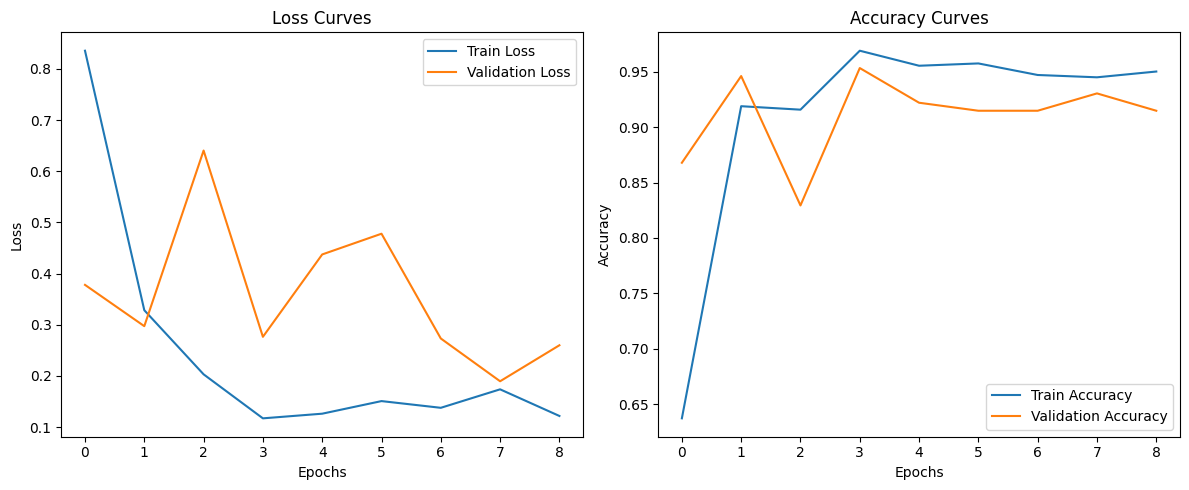

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(results["train_loss"], label="Train Loss")
plt.plot(results["val_loss"], label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(results["train_acc"], label="Train Accuracy")
plt.plot(results["val_acc"], label="Validation Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

save and load best model

In [32]:
# Save best model
torch.save(best_model.state_dict(), "best_model.pth")

# To load later
model = torchvision.models.efficientnet_b0(weights=None)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
)
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

test accuracy

In [39]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, pred = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

accuracy = 100 * correct / total

print(f'Accuracy: {accuracy}%')

Accuracy: 90.66666666666667%


pred function

In [46]:
from PIL import Image

def pred_img(model: torch.nn.Module,
             image_path: str,
             class_names: List[str],
             transform: torchvision.transforms = None,
             device: torch.device = "cuda" if torch.cuda.is_available() else "cpu"
             ) -> None:
    
    # Load the image
    img = Image.open(image_path)
    # Transform the image
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    #predict
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(0)
        target_image_pred = model(transformed_image.to(device))
        pred_probs = torch.softmax(target_image_pred, dim=1)
        pred_label = torch.argmax(pred_probs, dim=1)
        class_name = class_names[pred_label.item()]
        plt.figure()
        plt.imshow(img)
        plt.title(f"Predicted: {class_name} ({pred_probs.max().item():.2f})")
        plt.axis('off')

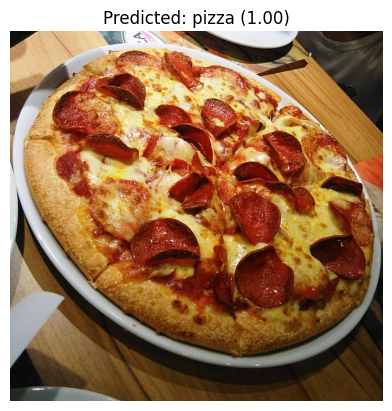

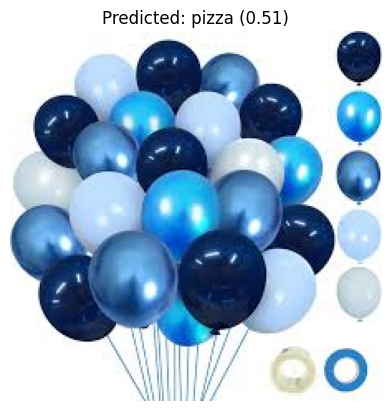

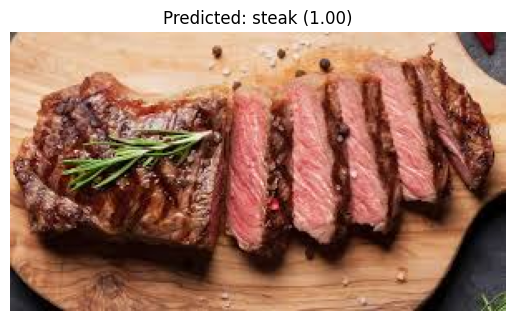

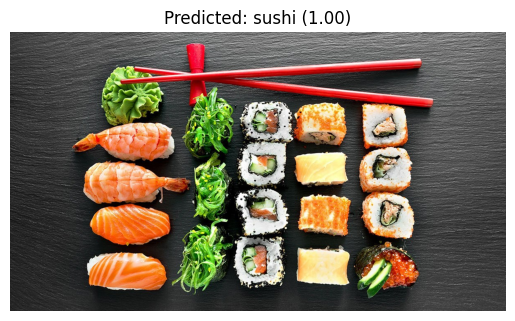

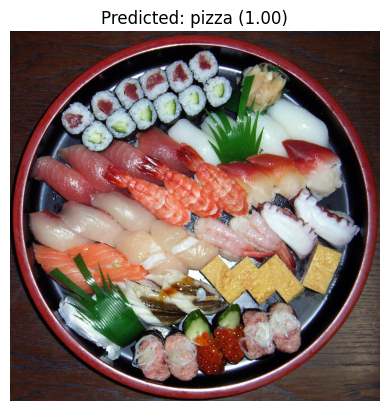

In [47]:
test_img_path = list(Path('./test_img').glob('*.jpg'))
for img_path in test_img_path:
    pred_img(model=model,
             image_path=img_path,
             class_names=class_names,
             transform=None,
             device="cuda" if torch.cuda.is_available() else "cpu")